## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from gammapy.data import DataStore
from gammapy.maps import Map, MapAxis, WcsGeom, WcsNDMap
from gammapy.cube import MapMaker, MapFit, PSFKernel
from gammapy.spectrum import (
    SpectrumExtraction,
    SpectrumFit,
    SpectrumResult,
    models,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)
from gammapy.spectrum.models import *
from gammapy.spectrum import (
    FluxPoints,
    SpectrumEnergyGroupMaker,
    FluxPointEstimator,
)

from gammapy.utils.energy import EnergyBounds
from gammapy.background.reflected import ReflectedRegionsBackgroundEstimator

import astropy.units as u
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord, Angle

In [2]:
!gammapy info


System:

	python_executable      : /Users/jer/anaconda/envs/gammapy-dev/bin/python 
	python_version         : 3.7.0      
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	path                   : /Users/jer/git/gammapy/gammapy/gammapy 
	version                : 0.9.dev7902 
	githash                : 93b4238ae6a3c36e605f77eaa16b9def0692b34d 


Other packages:

	numpy                  : 1.15.4     
	scipy                  : 1.1.0      
	matplotlib             : 3.0.2      
	cython                 : 0.29       
	astropy                : 3.0.5      
	astropy_healpix        : 0.3.1      
	reproject              : 0.4        
	sherpa                 : 4.10.1     
	pytest                 : 4.0.0      
	sphinx                 : 1.7.9      
	healpy                 : 1.12.5     
	regions                : 0.3        
	iminuit                : 1.3.3      
	naima                  : 0.8.1      
	uncertainties          : 3.0.3      


Gammapy environme

## Select observations
### Catalog inspection

We can choose among four catalogs provided in the CTA 1DC
- agn
- egal
- gc
- gps

In [3]:
data_store = DataStore.from_dir("$CTADATA/index/gps")

In [4]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /Users/jer/DATA/DC/1dc/index/gps
Rows: 19620
OBS_ID: 110000 -- 113269
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Observatory name: 'N/A'
Number of observations: 3270


In [5]:
data_store.obs_table[:5]

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes10,bytes8,bytes10,bytes8,int64,bytes21,bytes3,bytes13,bytes50,int64
110000,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662774400.0,662776192.0,2021-01-01,11:58:51,2021-01-01,12:28:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110000.fits,107301
110001,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662776320.0,662778112.0,2021-01-01,12:30:51,2021-01-01,13:00:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110001.fits,107374
110002,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662778240.0,662780032.0,2021-01-01,13:02:51,2021-01-01,13:32:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110002.fits,107579
110003,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662780160.0,662781952.0,2021-01-01,13:34:51,2021-01-01,14:04:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110003.fits,107224
110004,186.15609741,-64.019,300.0000158380702,-1.2999983233772607,0.0,90.0,0,1800.0,1764.0,0.98000001907,662782080.0,662783872.0,2021-01-01,14:06:51,2021-01-01,14:36:51,0,Galactic Plane Survey,1dc,South_z40_50h,1dc/1dc/data/baseline/gps/gps_baseline_110004.fits,107052


### Pointings and Target

We will target to galactic coordinates (38.5, 0) with no known sources.

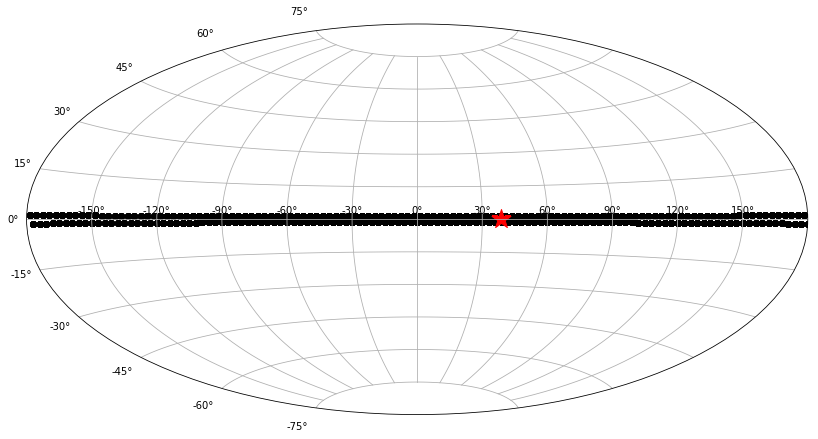

In [6]:
# Pointing positions
all_pointings = SkyCoord(data_store.obs_table['GLON_PNT'], data_store.obs_table['GLAT_PNT'], frame='galactic', unit='deg')  

# Plot pointings
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(
    all_pointings.l.wrap_at("180 deg").radian,
    all_pointings.b.wrap_at("180 deg").radian,
    color="k",
)
ax.grid(True)

#
#
# We define our selected position here !!! <---------------------------------
pos_target =  SkyCoord(38.5, 0, frame='galactic', unit='deg')

# Plot target
ax.scatter(
    pos_target.l.wrap_at("180 deg").radian, pos_target.b.radian, marker="*", s=400, c="red"
)

### Filter the observations

These observations have max **events offsets** of nearly 5 deg.

In [7]:
ob = data_store.obs(data_store.obs_table[1]['OBS_ID'])
ob.events.offset.max()

<Angle 4.999997 deg>

Let's filter observations taken in a radius of 2 deg of our target 

In [8]:
offset = pos_target.separation(all_pointings).deg
mask = offset < 1.5 # This is a True, False, True, False,... boolean mask 
table_selected = data_store.obs_table[mask]
table_selected

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,OBJECT,CALDB,IRF,EVENTS_FILENAME,EVENT_COUNT
int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,bytes10,bytes8,bytes10,bytes8,int64,bytes21,bytes3,bytes13,bytes50,int64
110627,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665625600.0,665627392.0,2021-02-03,11:58:51,2021-02-03,12:28:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110627.fits,100730
110628,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665627520.0,665629312.0,2021-02-03,12:30:51,2021-02-03,13:00:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110628.fits,100439
110629,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665629440.0,665631232.0,2021-02-03,13:02:51,2021-02-03,13:32:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110629.fits,100633
110630,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665631360.0,665633152.0,2021-02-03,13:34:51,2021-02-03,14:04:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110630.fits,100983
110631,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665633280.0,665635072.0,2021-02-03,14:06:51,2021-02-03,14:36:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110631.fits,100804
110632,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665635200.0,665636992.0,2021-02-03,14:38:51,2021-02-03,15:08:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110632.fits,100940
110633,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665637120.0,665638912.0,2021-02-03,15:10:51,2021-02-03,15:40:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110633.fits,100734
110634,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665639040.0,665640832.0,2021-02-03,15:42:51,2021-02-03,16:12:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110634.fits,100690
110635,286.79431152,4.80189991,38.999971648252284,-1.300006230670435,0.0,90.0,0,1800.0,1764.0,0.98000001907,665640960.0,665642752.0,2021-02-03,16:14:51,2021-02-03,16:44:51,0,Galactic Plane Survey,1dc,South_z20_50h,1dc/1dc/data/baseline/gps/gps_baseline_110635.fits,101152


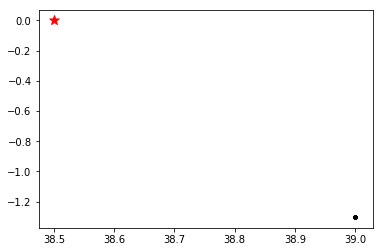

In [9]:
# Pointing positions
sel_pointings = SkyCoord(table_selected['GLON_PNT'], table_selected['GLAT_PNT'], frame='galactic', unit='deg')  

# Plot pointings
plt.scatter(
    sel_pointings.l,
    sel_pointings.b,
    color="k",
    s=10
)
ax.grid(True)

# Plot target
plt.scatter(
    pos_target.l, pos_target.b, marker="*", s=100, c="red"
)

## Make sky images

Let's havea look at the events of the first observation

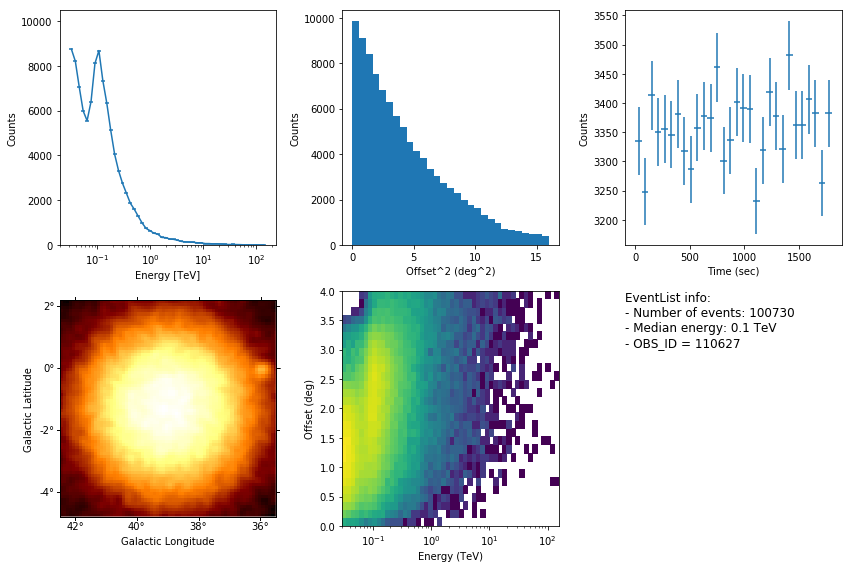

In [10]:
observations_selected = data_store.get_observations(table_selected['OBS_ID'])
events = observations_selected[0].events
events.peek()

There are about 94 000 events for a single observation, energy ranging from 1e-2 to 10 Tev.

We take as sumsample the whole selcted observations.

In [11]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1., 1., 10), unit="TeV", name="energy", interp="log"
)

In [12]:
geom = WcsGeom.create(
    skydir=pos_target,
    binsz=0.02,
    width=(5, 5),
    coordsys="GAL",
    proj="TAN",
    axes=[energy_axis],
)

In [13]:
%%time
maker = MapMaker(geom, offset_max="2.5 deg")
maps = maker.run(observations_selected)
images = maker.make_images()

CPU times: user 32.7 s, sys: 3.73 s, total: 36.4 s
Wall time: 37.7 s


In [14]:
maps.keys()

dict_keys(['counts', 'exposure', 'background'])

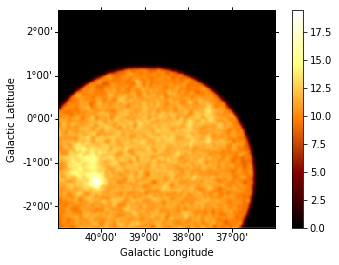

In [15]:
images["counts"].smooth(2).plot(add_cbar=True);

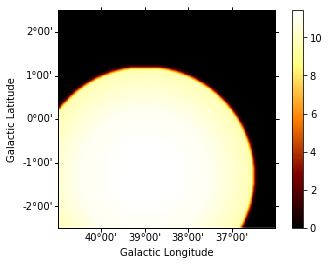

In [16]:
images["background"].smooth(2).plot(add_cbar=True);

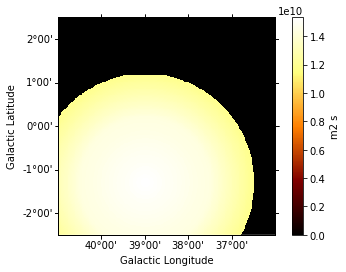

In [17]:
images["exposure"].plot(add_cbar=True);

In [18]:
excess = images["counts"].copy()
excess.data -= images["background"].data
images["excess"] = excess

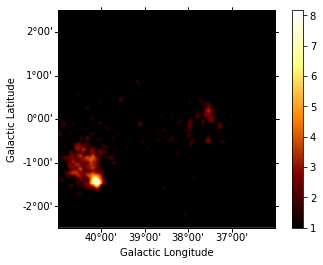

In [19]:
images["excess"].smooth(2).plot(add_cbar=True, vmin=1);
# we find no signal (counts>=1) in our region, centered in the image

In [20]:
pos_target

<SkyCoord (Galactic): (l, b) in deg
    (38.5, 0.)>

## Estimate CTA sensitivity with IRFs

In [21]:
from gammapy.irf import load_cta_irfs

from gammapy.stats import excess_matching_significance_on_off
from gammapy.spectrum.models import PowerLaw
from gammapy.spectrum.utils import CountsPredictor

### Load IRFs

In [22]:
# HDU INDEX
data_store.hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME
int64,bytes6,bytes10,bytes42,bytes24,bytes21
110000,events,events,../../data/baseline/gps,gps_baseline_110000.fits,EVENTS
110000,gti,gti,../../data/baseline/gps,gps_baseline_110000.fits,GTI
110000,aeff,aeff_2d,../../caldb/data/cta/1dc/bcf/South_z40_50h,irf_file.fits,EFFECTIVE AREA
110000,edisp,edisp_2d,../../caldb/data/cta/1dc/bcf/South_z40_50h,irf_file.fits,ENERGY DISPERSION
110000,psf,psf_3gauss,../../caldb/data/cta/1dc/bcf/South_z40_50h,irf_file.fits,POINT SPREAD FUNCTION
110000,bkg,bkg_3d,../../caldb/data/cta/1dc/bcf/South_z40_50h,irf_file.fits,BACKGROUND
110001,events,events,../../data/baseline/gps,gps_baseline_110001.fits,EVENTS
110001,gti,gti,../../data/baseline/gps,gps_baseline_110001.fits,GTI
110001,aeff,aeff_2d,../../caldb/data/cta/1dc/bcf/South_z40_50h,irf_file.fits,EFFECTIVE AREA


In [23]:
# OBSERVATIONS INDEX COLS of the selected observations
table_selected.colnames

['OBS_ID',
 'RA_PNT',
 'DEC_PNT',
 'GLON_PNT',
 'GLAT_PNT',
 'ZEN_PNT',
 'ALT_PNT',
 'AZ_PNT',
 'ONTIME',
 'LIVETIME',
 'DEADC',
 'TSTART',
 'TSTOP',
 'DATE-OBS',
 'TIME-OBS',
 'DATE-END',
 'TIME-END',
 'N_TELS',
 'OBJECT',
 'CALDB',
 'IRF',
 'EVENTS_FILENAME',
 'EVENT_COUNT']

In [24]:
table_selected['ONTIME', 'LIVETIME']

ONTIME,LIVETIME
float64,float64
1800.0,1764.0
1800.0,1764.0
1800.0,1764.0
1800.0,1764.0
1800.0,1764.0
1800.0,1764.0
1800.0,1764.0
1800.0,1764.0
1800.0,1764.0


In [25]:
total_time = ((table_selected['LIVETIME'][0]*19)/60/60) * u.Unit("h")
total_time

<Quantity 9.31 h>

In [26]:
irfs = load_cta_irfs("$CTADATA/caldb/data/cta/1dc/bcf/South_z40_50h/irf_file.fits")

In [27]:
for k, v in irfs.items():
    print(v)

EffectiveAreaTable2D
NDDataArray summary info
energy         : size =    42, min =  0.014 TeV, max = 177.828 TeV
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size =   252, min =  0.000 m2, max = 7238342.000 m2

Background3D
NDDataArray summary info
energy         : size =    21, min =  0.016 TeV, max = 158.489 TeV
fov_lon        : size =    36, min = -5.833 deg, max =  5.833 deg
fov_lat        : size =    36, min = -5.833 deg, max =  5.833 deg
Data           : size = 27216, min =  0.000 1 / (MeV s sr), max =  0.259 1 / (MeV s sr)

EnergyDispersion2D
NDDataArray summary info
e_true         : size =   500, min =  0.005 TeV, max = 495.450 TeV
migra          : size =   300, min =  0.005, max =  2.995
offset         : size =     6, min =  0.500 deg, max =  5.500 deg
Data           : size = 900000, min =  0.000, max = 27173.320



### Estimate sensitivity as the upper limit

From this point we could use Gammapy functions to estimate the sensitivity using for a set of given parameters:

- IRFs
- livetime of the observation
- alpha: On/OFF normalisation
- sigma: Minimum significance
- gamma_min: Minimum number of gamma-rays
- slope: Index of the spectral shape (Power-law)


The [`SensitivityEstimator`](https://docs.gammapy.org/dev/api/gammapy.spectrum.SensitivityEstimator.html?highlight=sensitivityestimator) function used to do this, but it is now being re-factored/work-in-progress.

The [CTA sensitivity notebook](https://docs.gammapy.org/0.8/notebooks/cta_sensitivity.html) used this function to estimate a sensitivity curve for CTA.

There are several [issues](https://github.com/gammapy/gammapy/issues/1943#issuecomment-441176466) filed in Gammapy Github repository about the actions undertaken to fix the `SensitivityEstimator` function. 


**Once this function will be fixed, we could come back to this notebook and finish it, defining the upper limit for a non-detection as de derived sensitivity estimation with value for the given parameters above.**
